# 1. Import Python Packages

To install the kernel used by NERSC-metatlas users, copy the following text to $HOME/.ipython/kernels/mass_spec_cori/kernel.json

```
{
 "argv": [
  "/global/common/software/m2650/python-cori/bin/python",
  "-m",
  "IPython.kernel",
  "-f",
  "{connection_file}"
 ],
 "env": {
    "PATH": "/global/common/software/m2650/python-cori/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin"
 },
 "display_name": "mass_spec_cori",
 "language": "python"
}
```

In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook

%matplotlib inline
%env HDF5_USE_FILE_LOCKING=FALSE
import sys, os

#### add a path to your private code if not using production code ####
#print ('point path to metatlas repo')
sys.path.insert(0,"/global/homes/v/vrsingan/repos/metatlas/") #where your private code is
######################################################################

from metatlas.helpers import dill2plots as dp
from metatlas.helpers import metatlas_get_data_helper_fun as ma_data
from metatlas.helpers import chromatograms_mp_plots as cp
from metatlas.helpers import chromplotplus as cpp
import metatlas.metatlas_objects as metob
from metatlas.helpers import mzmine_helpers as mzm

import qgrid

from ipywidgets import interact, interactive, fixed, IntProgress
import ipywidgets as widgets
from IPython.display import display, clear_output

import time
import dill
import numpy as np
import multiprocessing as mp
import pandas as pd

import glob
import re

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

def printmd(string):
    display(Markdown(string))

env: HDF5_USE_FILE_LOCKING=FALSE
('NERSC=', True)


## 2. Set atlas, project and output directories from your nersc home directory

1. Create a project folder name for this analysis by replacing the PROJECTDIRECTORY string text in red below.  Make sure to update the rest of the direcory to point to your home directory.  The pwd block will print out the directory where this jupyter notebook is stored.
2. Create a subdirectory name for the output, each run through you may want to create a new output folder.
3. When you run the block the folders will be created in your home directory.  If the directory already exists, the block will just set the path for use with future code blocks.

In [3]:
project_directory='/global/homes/FIRST-INITIAL-OF-USERNAME/USERNAME/PROJECTDIRECTORY/'  # <- edit this line, do not copy the path directly from NERSC (ex. the u1, or u2 directories)
output_subfolder='HILIC_POS_20190830/'  # <- edit this as 'chromatography_polarity_yyyymmdd/'
output_dir = os.path.join(project_directory,output_subfolder)
output_data_qc = os.path.join(output_dir,'data_QC')

if not os.path.exists(project_directory):
   os.makedirs(project_directory)
if not os.path.exists(output_dir):
   os.makedirs(output_dir)
if not os.path.exists(output_data_qc):
    os.makedirs(output_data_qc)

## 3. Select groups and get QC files

In [21]:
dp = reload(dp)
groups = dp.select_groups_for_analysis(name = '%20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560%',
                                       most_recent = True,
                                       remove_empty = True,
                                       include_list = ['QC'], exclude_list = [])  #['QC','Blank']

1
(0, u'20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_vrs1_QC', datetime.datetime(2019, 10, 18, 23, 6, 24))


In [22]:
for g in groups:
    for f in g.items:
         print f.name

20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_8_1S-Set1-B_2_-Salt-QC_82.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_59_12-Ctrl-Set2-B_4_-noD2O-QC_304.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_27_4S-Set1-B_3_-Salt-QC_119.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Pre_--QC_6.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_7_1S-Set1-B_1_-Salt-QC_45.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_69_12-ColdwD2O-Set2-B_2_-D2O-QC_230.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_73_24-Ctrl-Set2-B_2_-noD2O-QC_193.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_56_12-Ctrl-Set2-B_1_-noD2O-QC_156.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_202_ExCtrl-Set2-B_3_-ExCtrl-QC_267.mzML
20190308_KBL_IG-SS_BETO_Algae_Mono26B_HF_LipV7_47560_FPS_MS1_0_QC_Post_--QC_345.mzML


## 4. Get template QC atlas from database

In [15]:
#Atlas File Name 
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Template' # RT space
CPD = 'QCv3' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity

QC_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL))

atlases = metob.retrieve('Atlas',name=QC_template_filename,
                         username='vrsingan')
names = []
for i,a in enumerate(atlases):
    print(i,a.name,pd.to_datetime(a.last_modified,unit='s'),len(a.compound_identifications))

(0, u'MSMLS_HILICz150mm_Annotation20190824_Template_QCv3_Unlabeled_Positive', Timestamp('2020-02-28 16:14:28'), 72)


In [16]:
# #Alternatively use this block to create QC atlas from spreadsheet
# import datetime
#dp = reload(dp)

# LCS = 'MSMLS' # Library Compound Set
# CTY = 'HILICz150mm' # Chromatography
# LR = 'Annotation20190824' # Library Run
# RTS = 'Template' # RT space
# CPD = 'QCv3' # Set of Compounds
# LAB = 'Unlabeled' # Isolabeling
# POL = 'Positive' # Polarity
# DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')
# QC_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

#myAtlas = dp.make_atlas_from_spreadsheet('/global/project/projectdirs/metatlas/projects/1_TemplateAtlases/TemplateAtlas_HILICz150mm_Annotation20190824_QCv3_Unlabeled_Positive.csv',
#                                       QC_template_filename,
#                                        filetype='csv',
#                                        sheetname='',
#                                        polarity = 'positive',
#                                        store=True,
#                                       mz_tolerance = 20)
#atlases = dp.get_metatlas_atlas(name=QC_template_filename,do_print = True,most_recent=True)

In [17]:
myAtlas = atlases[-1]
atlas_df = ma_data.make_atlas_df(myAtlas)
atlas_df['label'] = [cid.name for cid in myAtlas.compound_identifications]
print myAtlas.name
print myAtlas.username

((72, 15), 72)
MSMLS_HILICz150mm_Annotation20190824_Template_QCv3_Unlabeled_Positive
vrsingan


## 4b. Uncomment the block below to adjust RT window

In [18]:
# rt_allowance = 0.5
# atlas_df['rt_min'] = atlas_df['rt_peak'].apply(lambda rt: rt-rt_allowance)
# atlas_df['rt_max'] = atlas_df['rt_peak'].apply(lambda rt: rt+rt_allowance)

# 5. Create metatlas dataset from QC files and QC atlas

In [23]:
all_files = []
for my_group in groups:
    for my_file in my_group.items:
        all_files.append((my_file,my_group,atlas_df,myAtlas))
        
pool = mp.Pool(processes=min(4, len(all_files)))
t0 = time.time()
metatlas_dataset = pool.map(ma_data.get_data_for_atlas_df_and_file, all_files)
pool.close()
pool.terminate()
#If you're code crashes here, make sure to terminate any processes left open.
print time.time() - t0

5.0571641922


# 6. Create RT adjustment model

In [25]:
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import mean_absolute_error as mae

ransac = RANSACRegressor(random_state=42)
qc_actual_df = dp.make_output_dataframe(input_dataset = metatlas_dataset, fieldname='rt_peak', use_labels=True) # Peak height filter??
maes, coefs, intercepts = [],[],[]
actual_rts, pred_rts = [],[]
for i in range(qc_actual_df.shape[1]):
    current_actual_df = qc_actual_df.loc[:,qc_actual_df.columns[i]]
    bad_qc_compounds = np.where(~np.isnan(current_actual_df))
    current_actual_df = current_actual_df.iloc[bad_qc_compounds]
    current_pred_df = atlas_df.iloc[bad_qc_compounds][['rt_peak']]
    actual_rts.append(current_actual_df.values.tolist())
    pred_rts.append(current_pred_df.values.tolist())
    
    rt_model = ransac.fit(current_pred_df, current_actual_df)
    
    coefs.append(rt_model.estimator_.coef_[0])
    intercepts.append(rt_model.estimator_.intercept_)
    maes.append(mae(rt_model.estimator_.coef_*current_pred_df+
                   rt_model.estimator_.intercept_, current_actual_df))

## 7. Plot MAE (mean absolute error) for all QC files  
Index and file name of the QC file with the least MAE is highlighted.<br />
Dark Red and Dark Blue lines represent Coeff and Intercept values for each of the QC files.<br /> 
Light Red and Light Blue lines show the median Coeff and Intercept value.

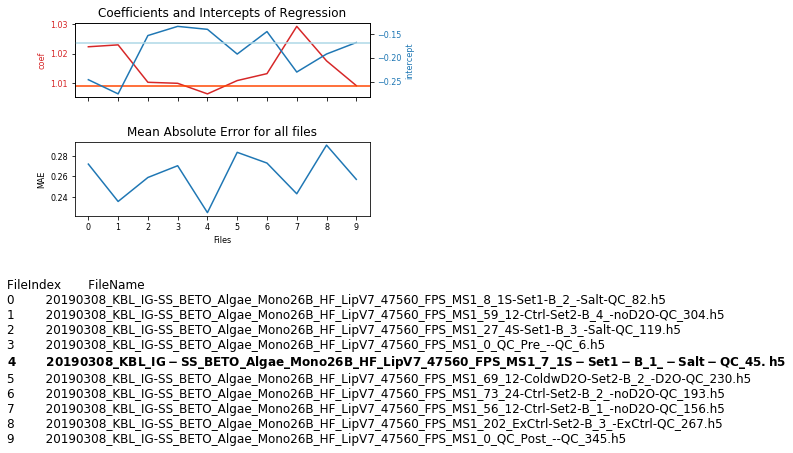

In [26]:
from sklearn.metrics import mean_absolute_error as mae

fig_legend = "FileIndex       FileName"
for i in range(qc_actual_df.shape[1]):
    if maes[i] == min(maes):
        QCFileIndex = i
        fname = qc_actual_df.columns[i][1].replace("_", "\_")
        fig_legend = fig_legend+ "\n" + r"$\bf{"+ str(i)+ "}$"+"\t"+ r"$\bf{"+str(fname)+"}$"
    else:
        fig_legend = fig_legend+"\n"+str(i)+"        "+qc_actual_df.columns[i][1]

plt.rc('font', size=10)
plt.rc('axes', labelsize=8)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
fig, axes = plt.subplots(2, sharex=True)
color = 'tab:red'
axes[0].set_ylabel('coef', color=color)
axes[0].plot(coefs, color=color)
axes[0].tick_params(axis='y', labelcolor=color)
axes[0].axhline(y=np.median(rt_model.estimator_.coef_),color='orangered')

ax2 = axes[0].twinx()
color = 'tab:blue'
ax2.set_ylabel('intercept', color=color)  
ax2.plot(intercepts, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=np.median(rt_model.estimator_.intercept_),color='lightblue')
ax2.set_title('Coefficients and Intercepts of Regression')

axes[1].plot(maes)
axes[1].set_xticks(np.arange(len(maes)))
axes[1].set_ylabel('MAE')
axes[1].set_xlabel('Files')
axes[1].set_title('Mean Absolute Error for all files')

fig.tight_layout(pad=2.5)
plt.text(0,-0.6, fig_legend, fontsize=12, transform=plt.gcf().transFigure)
plt.savefig(os.path.join(output_data_qc,'MAE_allFiles.pdf'), bbox_inches="tight")

## 8. Plot actual vs predict RT values and fit a  median coeff+intercept line

/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/figure.py:2223: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.     You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplotswith the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure "


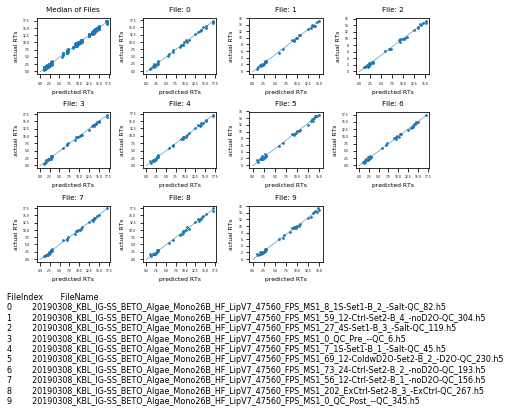

In [27]:
#User can change to use particular qc file
import itertools
import math
from matplotlib import gridspec

x = list(itertools.chain(*pred_rts))
y = list(itertools.chain(*actual_rts))

coef = np.median(coefs)
intercept = np.median(intercepts)

rows = int(math.ceil((qc_actual_df.shape[1]+1)/3))
cols = 4
gs = gridspec.GridSpec(rows, cols)
plt.rc('font', size=6)
plt.rc('axes', labelsize=6)
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=3)
fig = plt.figure(constrained_layout=True)

ax = fig.add_subplot(gs[0])
ax.scatter(x,y, s=3)
ax.plot(np.linspace(0, max(x), 100), coef*np.linspace(0, max(x), 100)+intercept, linewidth=0.5)
ax.set_title("Median of Files")
ax.set_xlabel('predicted RTs')
ax.set_ylabel('actual RTs')

for i in range(qc_actual_df.shape[1]):
    coef = coefs[i]
    intercept = intercepts[i]
    x = list(itertools.chain(*pred_rts[i]))
    y = actual_rts[i]
    
    ax = fig.add_subplot(gs[i+1])
    ax.scatter(x, y, s=3)
    ax.plot(np.linspace(0, max(x),100), coefs[i]*np.linspace(0,max(x),100)+intercept, linewidth=0.5)
    ax.set_title("File: "+str(i))
    ax.set_xlabel('predicted RTs')
    ax.set_ylabel('actual RTs')
    
fig_legend = "FileIndex       FileName"
for i in range(qc_actual_df.shape[1]):
    fig_legend = fig_legend+"\n"+str(i)+"        "+qc_actual_df.columns[i][1]

fig.tight_layout()
plt.text(0,-0.4, fig_legend, fontsize=8, transform=plt.gcf().transFigure)
plt.savefig(os.path.join(output_data_qc, 'Actual_vs_Predicted_RTs.pdf'), bbox_inches="tight")

## 9. Plot actual vs predict RT values and fit a coeff+intercept line for a specific QC file (optional)

Use this if you want coef and intercept of a particular QC file for prediction instead of the median values from all QC files 

Text(0,0.5,'actual RTs')

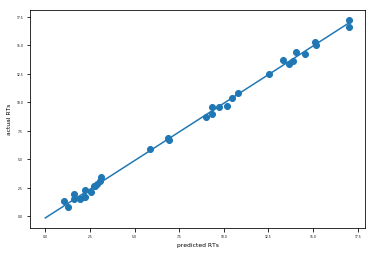

In [28]:
# #QCFileIndex = 1
# coef = coefs[QCFileIndex]
# intercept = intercepts[QCFileIndex]

# x = list(itertools.chain(*pred_rts[QCFileIndex]))
# y = actual_rts[QCFileIndex]

# plt.scatter(x, y)
# plt.plot(np.linspace(0, max(x),100), coef*np.linspace(0,max(x),100)+intercept)
# plt.xlabel('predicted RTs')
# plt.ylabel('actual RTs')

## 10. Save RT model (optional)

In [29]:
# Save model
with open(os.path.join(output_data_qc,'rt_model.txt'), 'w') as f:
   f.write('coef = {}\nintercept = {}\nqc_actual_rts = {}\nqc_predicted_rts = {}'.format(coef, 
                                                                intercept, 
                                                                ', '.join([g.name for g in groups]),
                                                                myAtlas.name))
   f.write('\n'+repr(rt_model.set_params()))

## 11. Auto RT adjust original QC atlas

In [30]:
import datetime

#Atlas File Name
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Predicted' # RT space
CPD = 'QCv3' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity
FT = '' # Free Text
DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')


if FT != '':
    QC_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,FT,DT))
else:
    QC_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

atlas_df = ma_data.make_atlas_df(myAtlas)
QC_atlas_df = atlas_df.copy()
QC_atlas_df['rt_peak'] = QC_atlas_df['rt_peak'].apply(lambda rt: coef*rt+intercept)
QC_atlas_df['rt_min'] = QC_atlas_df['rt_peak'].apply(lambda rt: rt-.5)
QC_atlas_df['rt_max'] = QC_atlas_df['rt_peak'].apply(lambda rt: rt+.5)

QC_atlas_df.to_csv(os.path.join(output_data_qc, QC_predicted_filename), index=False)

all_files = []
for my_group in groups:
    for my_file in my_group.items:
        all_files.append((my_file,my_group,QC_atlas_df,myAtlas))

pool = mp.Pool(processes=min(4, len(all_files)))
t0 = time.time()
metatlas_dataset = pool.map(ma_data.get_data_for_atlas_df_and_file, all_files)
pool.close()
pool.terminate()
#If you're code crashes here, make sure to terminate any processes left open.
print time.time() - t0

group = 'index' # 'page' or 'index' or None
save = True
share_y = True
dp.make_chromatograms(input_dataset=metatlas_dataset, group=group, share_y=share_y, save=save, output_loc=output_data_qc)

((72, 15), 72)
4.76436400414


/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/global/homes/v/vrsingan/repos/metatlas/metatlas/helpers/chromplotplus.py:152: RuntimeWarning: invalid value encountered in less_equal
  for i,e in enumerate(eic_lines)]
/global/homes/v/vrsingan/repos/metatlas/metatlas/helpers/chromplotplus.py:58: RuntimeWarning: All-NaN axis encountered
  self.intensity_max = np.nanmax([c.intensity_max_inbounds for c in self.compound_eics])
/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/globa

/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/font_manager.py:1338: UserWarning: findfont: Could not match :family=Helvetica:style=normal:variant=normal:weight=normal:stretch=normal:size=2.46153846154. Returning /global/homes/v/vrsingan/.conda/envs/vs_test1/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/afm/phvlo8a.afm
  UserWarning)
/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/font_manager.py:1338: UserWarning: findfont: Could not match :family=Helvetica:style=normal:variant=normal:weight=bold:stretch=normal:size=2.46153846154. Returning /global/homes/v/vrsingan/.conda/envs/vs_test1/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/afm/phvlo8a.afm
  UserWarning)
/global/common/software/m2650/python-cori/lib/python2.7/site-packages/matplotlib/font_manager.py:1338: UserWarning: findfont: Could not match :family=Helvetica:style=normal:variant=normal:weight=bold:stretch=normal:size=1.88235294118. Returning /

## 12. Save adjusted QC to database

In [ ]:
dp.make_atlas_from_spreadsheet(QC_atlas_df,
                          QC_predicted_filename,
                          filetype='dataframe',
                          sheetname='',
                          polarity = 'positive',
                          store=True,
                          mz_tolerance = 20)

## 13. Auto RT adjust template EMA atlas

In [ ]:
import datetime

#Atlas File Name
LCS = 'MSMLS' # Library Compound Set
CTY = 'HILICz150mm' # Chromatography
LR = 'Annotation20190824' # Library Run
RTS = 'Template' # RT space
CPD = 'EMA' # Set of Compounds
LAB = 'Unlabeled' # Isolabeling
POL = 'Positive' # Polarity
FT = '' # Free Text
DT = datetime.datetime.strftime(datetime.datetime.now(),'%Y%m%d')

EMA_template_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL))

RTS = 'Predicted' # RT space
if FT != '':
    EMA_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,FT,DT))
else:
    EMA_predicted_filename = "_".join((LCS,CTY,LR,RTS,CPD,LAB,POL,DT))

atlases = metob.retrieve('Atlas',name=EMA_template_filename,
                         username='vrsingan')
myAtlas = atlases[-1]
EMA_atlas_df = ma_data.make_atlas_df(myAtlas)
EMA_atlas_df['label'] = [cid.name for cid in myAtlas.compound_identifications]

EMA_atlas_df['rt_peak'] = EMA_atlas_df['rt_peak'].apply(lambda rt: coef*rt+intercept)
EMA_atlas_df['rt_min'] = EMA_atlas_df['rt_peak'].apply(lambda rt: rt-.5)
EMA_atlas_df['rt_max'] = EMA_atlas_df['rt_peak'].apply(lambda rt: rt+.5)

EMA_atlas_df.to_csv(os.path.join(output_data_qc,EMA_predicted_filename), index=False)

# Optionally save in database
#dp.make_atlas_from_spreadsheet(EMA_atlas_df,
#                           EMA_predicted_filename,
#                           filetype='dataframe',
#                           sheetname='',
#                           polarity = 'positive',
#                           store=True,
#                           mz_tolerance = 20)